# MAC and Model Correction or Updating of the FE models using Test Data
#### By Sainag Immidisetty






In [1]:
%load_ext autoreload
%autoreload 2
import pylab
import mpld3
import vibrationtesting as vt
from vibrationtesting import sos_modal
import matplotlib.pyplot as plt
import scipy
import numpy as np
import scipy.io as sio
import array_to_latex as a2t
from scipy.sparse import *
np.set_printoptions(precision = 9, linewidth = 220, suppress = True)

##### Purpose of bridging the gap between Testing and FE-Simulation:

Product development process have been modifying every now and then, at present most of the companies don't use simulation unless they first establish trust. So, first preference is given to validation at the test condition to use the right modeling techniques in simulation so that the variations can be looked at and the model could be used for development a head of time to see certain phenomenon that would replicate real world. 


## The Wing Structure:

Length, Width, Thickness and Airfoil profile coordinates were collected from this Structure to create a FE-models:

Ideally if we want to do a free-free test, we need to mount the structure to spring or bungee cords with a very low resonance frequency but as the first resonance is quite high so clamping on one-end is not a bad idea.

![alt](img/image[4].jpeg )
Note: Shaker placement in the picture was wrong, this will be explained below.

# FE-Model:

Three wing models were studied using Beam Elements, Brick Elements, and SHELL elements. 

### Beam Element model: 

A Matlab code was developed to solve different problems using 3D beam/rod/torsion element inside WFEM module by simply creating an input file.  The following were the resultant natural frequencies and mode shapes:




![alt](img/Beammodelmode1.jpg) | ![alt](img/Beammodelmode2.jpg) | ![alt](img/Beammodelmode3.jpg) | 
![alt](img/Beammodelmode4.jpg) | ![alt](img/Beammodelmode5.jpg) | ![alt](img/Beammodelmode6.jpg)


### Brick Element model:

Similar to Beam code, an 8 noded Brick element was developed. The following are results obtained:



![alt](img/Brickmodelmode1.jpg) | ![alt](img/Brickmodelmode2.jpg) | ![alt](img/Brickmodelmode3.jpg) 

![alt](img/Brickmodelmode4.jpg) | ![alt](img/Brickmodelmode5.jpg) | ![alt](img/Brickmodelmode6.jpg)



### Observations:

1. Beam model gave better results with lesser mesh compared to Brick model. Thereby saving computational time.

# Experimental Modal Analysis :



**System Analysis**: Combined processing of an excitation and response signals, representing the device under test (DUT) natural responses or resonances, with no other disturbances.

System Analysis can be expanded to almost any complex structure. For instance, an engine 
![alt](img/excitation_response.png)

System Analysis primarily calculates the Frequency Response which is the response divided by the excitation.

![Ideal System(no noise)](img/idealsystem)

The general assumption while doing modal analysis is that the system is linear. However, that is not always true. Linearity check of the system was done experimentally and explained below.

### Demonstration of Time and Frequency Responses for the wing model: (MDOF system)

(0, 350)

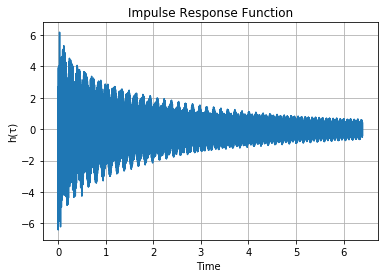

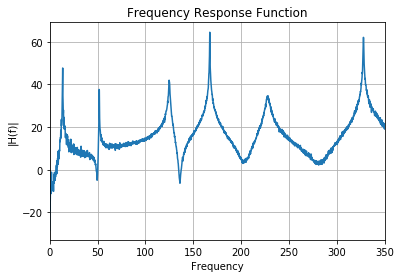

In [2]:
%matplotlib inline
mat_contents=sio.loadmat('SystemAnalysis/1.mat')

Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
H = mat_contents['Hf_chan_2']


Time = mat_contents['Time_domain']
h = mat_contents['Time_chan_2']

             
fig=plt.figure()
plt.title('Impulse Response Function')
plt.plot(Time, h)
plt.xlabel('Time ')
plt.ylabel('h(τ)')
plt.grid()

fig=plt.figure()
plt.title('Frequency Response Function')
plt.plot(Frequency, 20*np.log10(abs(H)))
plt.xlabel('Frequency')
plt.ylabel('|H(f)|')
plt.grid()
plt.xlim(xmax=350, xmin=0)


## Transducers and Exciters used:


A minimum of two channels are required to measure the signals coming out of the sensors simultaneously to do modal testing. Typically, Channel-1 corresponds to the impact hammer/electromagnetic shaker and Channel-2 to the accelerometer.

### Accelerometers: 

Accelerometers are very important in the process of data collection, there is nothing worst than using a pretty good transducer for a wrong job because that will not result in good data and could destroy the transducer.



**Considerations**:
- Type:
- Weight:
- Sensitivity:
- Mounting:
- Triax vs. Uniax:

### Impact Hammers:

### Shakers:





## Dual Channel FFT Analysis




* Simultaneous measurements at the input and output are performed.
* The input and output autospectra which is nothing but the root mean square, simple way to look is we square the signal by itself then take a mean and a square root.
* The cross spectrum between the input and output are measured. Here, we multiply one signal with another different signal and that gives us relative phase.
* Many other functions can be calculated from the basic, measured data.


![alt](img/Dualchannelspectrum)**Note:** This chart has not changed since 30 years. However, the number of channels have been considerably increased. From one excitation - one response to one excitation - multiple response to multiple excitation - multiple response. 

**Description of the Chart above:**
Assume channel.A corresponds to excitation and Channel.B to response, we gather time data through the A/D converter and anti-aliasing filter, then do Fourier transformation to get a fourier spectrum and as we do averaging we multiply signals by themselves that gives the name Gaa and Gbb (Autospectrum, has no phase) whose inverse fourier transform gives Auto correlation(Raa and Rbb). Both the signals from Fourier spectrum are brought together to calculate the Cross-spectrum(Gab) where phase is preserved. 
With the cross spectrum and the auto spectrum we can calculate the FRF and the Coherence which are valuable functions. The other functions are not quite often used in Modal, essentially, we use the FRF, the Coherence and the Impulse response(by taking inversed fourier transform of Frequency Response). 




**Advantages of Dual-channel FFT Analysis:**

* Phase information is available. Phase gives complete description of the structure and we will be able to do proper animation as well.
* Effects of noise are minimized through AVERAGING. Note: when we excite the structure with the miniature shaker, the signal that we use is called random noise. However, it's random excitation. Noise which is minimized here is external vibration or forces that are not coming out of the generator that disturb our measurement. So, that uncorrelated contribution from environmental vibration will be  reduce by averaging.
* A controlled input signal is not needed. So, controlling the excitation amplitude and frequency tightly is not a requirement because if the force spectrum is going up and down within like 20-30 dB, it's not a big deal because the transducer has a large dynamic range and also the front end (160 dB typically) so we can measure every thing accurately. The response will follow the excitation profile to some degree. And once we combine the two different signals together they will normalize.
* Easy tool to use once we know how to set up the Analyzer.
* Extension, for instance to Modal Analysis.

**Pitfalls of Dual-channel FFT Analysis:**

* Leakage
* A linear system is assumed


###  Leakage: 

It is the result of underestimating the peak either at the valley or at the resonance.

** To prevent leakage:**

1. Use optimum time weighting function
2. Increase the resolution
3. Choose optimum excitation


#### 1. Using Optimum time weighting function:

 It is a result of not having time data acquisition until infinite time. In reality, we have the beginning and the end. So, we need to add some weighting to prevent leakage.


**Ideal Case**: It almost never happens for a signal like sine wave containing even number of cycles which means that the beginning and the end of time is continuous. Because the FFT process takes that time data block, loop it and analyze constantly so it looks perfectly continuous and thats the ideal case which do not require windowing to prevent leakage. If we add window to that case then that would over estimate damping making the mode look wider than it should be.
![alt](img/idealcase)
**Real cases require window to prevent leakage to some extent**: Real world time data is collected as a block which has a size and is not continuous at the beginning and the end. When we do FFT there will be drop in amplitude, poor spectrum filter profile. So, we need to apply weighting functions to control leakage as much as possible.  
![alt](img/realcase)

### Demonstration of windowing with Exponential for Impact time response and Hanning for Random response

expwin is untested


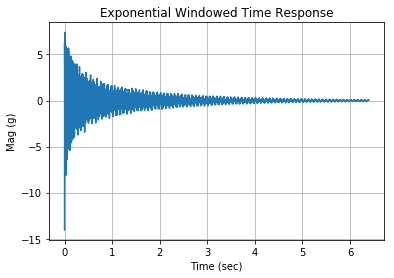

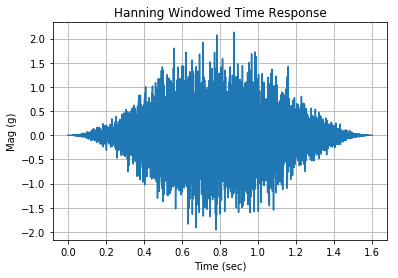

In [3]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/rawdata_1.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
a=vt.expwin(len(Time_data),ts=2)
Time_data= np.transpose(Time_data)
rawresponse1= mat_contents['Time_chan_2']
rawresponse1 = np.array(rawresponse1)
windowedsig= np.transpose(rawresponse1)*a

fig=plt.figure()
plt.title('Exponential Windowed Time Response')
plt.plot(Time_data.T, windowedsig.T)
plt.xlabel('Time (sec)')
plt.ylabel('Mag (g)')
plt.grid()

mat_contents=sio.loadmat('linearitycheck/high.mat')
Time_data= mat_contents['Time_domain'] 
Time_data= np.array(Time_data)
a=vt.hanning(len(Time_data))
averagedsig= mat_contents['Time_chan_2']
Time_data= np.transpose(Time_data)

averagedsig = np.array(averagedsig)
windowedsig= np.transpose(averagedsig)*a
fig=plt.figure()
plt.title('Hanning Windowed Time Response')
plt.plot(Time_data.T, windowedsig.T)
plt.xlabel('Time (sec)')
plt.ylabel('Mag (g)')
plt.grid()

### Demonstrating window affecting the spectrum as explained above:

expwin is untested


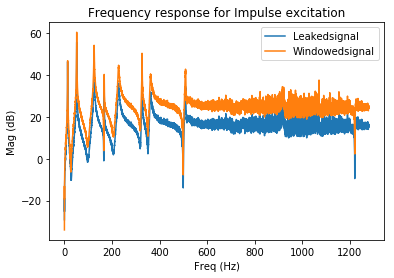

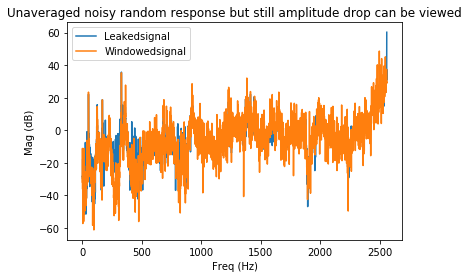

In [4]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/rawdata_1.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
a=vt.expwin(len(Time_data))
Time_data= np.transpose(Time_data)
rawimpact1 = mat_contents['Time_chan_1']
rawimpact1 = np.array(rawimpact1)
rawresponse1= mat_contents['Time_chan_2']
rawresponse1 = np.array(rawresponse1)
windowedresponse1= np.transpose(rawresponse1)*a

x=np.array([rawresponse1]).reshape(1,16384,1)

xwindowed=np.array([windowedresponse1]).reshape(1,16384,1)

f=np.array([rawimpact1]).reshape(1,16384,1)

[freq,Pxx]=vt.asd(x,Time_data,windowname="none")
[freq,Pff]=vt.asd(f,Time_data,windowname="none")
[freq,Pxf]=vt.crsd(f,x,Time_data,windowname="none")

[freq,Pxxwindowed]=vt.asd(xwindowed,Time_data,windowname="none")
[freq,Pxfwindowed]=vt.crsd(f,xwindowed,Time_data,windowname="none")

Pxx= np.array([Pxx]).reshape(1,8193)

freq=np.array([freq]).reshape(1,8193)

freq=np.array(freq)
H1=np.conj(Pxf/Pff)
H1=np.array([H1]).reshape(1,8193)
H1=np.array(H1)

H1windowed=np.conj(Pxxwindowed/Pxfwindowed)
H1windowed=np.array([H1windowed]).reshape(1,8193)

FRFs= np.column_stack((H1,H1windowed))
FRFs=np.array(FRFs)


fig = plt.figure()
ax = plt.subplot(111)
ax.plot(freq.T, 20*np.log10(abs(H1)).T, label='Leakedsignal')
ax.plot(freq.T, 20*np.log10(abs(H1windowed)).T, label='Windowedsignal')
plt.title('Frequency response for Impulse excitation')
plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
ax.legend()
plt.show()

mat_contents=sio.loadmat('linearitycheck/high.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
a=vt.hanning(len(Time_data))
Time_data= np.transpose(Time_data)
rawimpact1 = mat_contents['Time_chan_1']
rawimpact1 = np.array(rawimpact1)
rawresponse1= mat_contents['Time_chan_2']

rawresponse1 = np.array(rawresponse1)
windowedresponse1= np.transpose(rawresponse1)*a


x=np.array([rawresponse1]).reshape(1,8192,1)


xwindowed=np.array([windowedresponse1]).reshape(1,8192,1)

f=np.array([rawimpact1]).reshape(1,8192,1)

[freq,Pxx]=vt.asd(x,Time_data,windowname="none")
[freq,Pff]=vt.asd(f,Time_data,windowname="none")
[freq,Pxf]=vt.crsd(f,x,Time_data,windowname="none")

[freq,Pxxwindowed]=vt.asd(xwindowed,Time_data,windowname="none")
[freq,Pxfwindowed]=vt.crsd(f,xwindowed,Time_data,windowname="none")

Pxx= np.array([Pxx]).reshape(1,4097)

freq=np.array([freq]).reshape(1,4097)
freq=np.array(freq)
H1=np.conj(Pxf/Pff)
H1=np.array([H1]).reshape(1,4097)
H1=np.array(H1)
H1windowed=np.conj(Pxxwindowed/Pxfwindowed)
H1windowed=np.array([H1windowed]).reshape(1,4097)
FRFs= np.column_stack((H1,H1windowed))
FRFs=np.array(FRFs)


fig = plt.figure()
ax = plt.subplot(111)
ax.plot(freq.T, 20*np.log10(abs(H1)).T, label='Leakedsignal')
ax.plot(freq.T, 20*np.log10(abs(H1windowed)).T, label='Windowedsignal')
plt.title('Unaveraged noisy random response but still amplitude drop can be viewed')
plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
ax.legend()
plt.show()

#### 2. Leakage due to less Resolution: 

* when resolution is low, that means that there are less points to represent the curves digitally and these points need not necessarily be at the maximum. So, this could cause a reduction in amplitude underestimating the peak either at the resonance or the valley or both. 
* So, in order to reduce the leakage we need to increase the resolution which means to measure for longer period of time and we can also reduce the leakage by choosing H2 for resonance and H1 for the anti-resonance.


#### Demonstrating leakage due to resolution with Random Excitation:
- Shaker was ran in random mode and seen the impact of different settings on the coherence and noticed how this can impact the system.
- Initialized the test and one volt was the maximum that we it could generate and the level can be controlled by scrolling the bar up and down to adjust in terms of percentage for security reasons but here I used 100% as it's fine to use full 1 volt as here we have a bigger system to shake with that high force. For instance, if we test on a satellite which is million dollar worth then we got to be careful but here it doesn't matter so much.(because it's University's property, just kidding!)
- So, the pure random excitation upto 2KHz was used with a poor frequency resolution of 8Hz wich means we measured the data for 1/8th of a second. 
**Observation from the FRF:**
- We can see the FRFs are not clean and also have big drops at resonance, it means that we have lot of leakage as peak is suppose to be sharp. So, we have very poor definition around the resonance because we have very few points there.

**Improving resolution:**
- Since we found that there is leakage, now we went from 400 lines FFT with 8 Hz resolution to 1 Hz resolution which means we measure for 1 second. So spending more time is the price to pay for the data quality. However, we can see the frequency response was nicely defined before than before and the coherence has been significantly improved.

%matplotlib inline
mat_contents=sio.loadmat('linearitycheck/high.mat')
Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
#Frequency= np.transpose(Frequency)
Highresponse = mat_contents['Hf_chan_2']
Highresponse = np.array(Highresponse)
PSDHighresponse = mat_contents['PSD_chan_2']
PSDHighresponse = np.array(PSDHighresponse)
PSDHighLevelRandom = mat_contents['PSD_chan_1']
PSDHighLevelRandom = np.array(PSDHighLevelRandom)
coh = mat_contents['Hf_coh_chan_2']
coh = np.array(coh)

mat_contents=sio.loadmat('linearitycheck/med.mat')

mediumresponse = mat_contents['Hf_chan_2']
mediumresponse = np.array(mediumresponse)
PSDmediumresponse = mat_contents['PSD_chan_2']
PSDmediumresponse = np.array(PSDmediumresponse)
PSDmediumLevelRandom = mat_contents['PSD_chan_1']
PSDmediumLevelRandom = np.array(PSDmediumLevelRandom)
mat_contents=sio.loadmat('linearitycheck/low.mat')

lowresponse = mat_contents['Hf_chan_2']
lowresponse = np.array(lowresponse)
PSDlowresponse = mat_contents['PSD_chan_2']
PSDlowresponse = np.array(PSDlowresponse)
PSDlowLevelRandom = mat_contents['PSD_chan_1']
PSDlowLevelRandom = np.array(PSDlowLevelRandom)

FRFs= np.column_stack((lowresponse,mediumresponse,Highresponse))
VibAutospectrum= np.column_stack((PSDlowresponse,PSDmediumresponse,PSDHighresponse))
ForceAutospectrum= np.column_stack((PSDlowLevelRandom,PSDmediumLevelRandom,PSDHighLevelRandom))
FRFs=np.array(FRFs)
VibAutospectrum=np.array(VibAutospectrum)
ForceAutospectrum=np.array(ForceAutospectrum)
#fig=plt.figure()
#plt.title('Impact PSD')
#plt.plot(Frequency.T, 20*np.log10(abs(Highresponse)).T)
#plt.plot(Frequency.T, 20*np.log10(abs(medresponse)).T)
#plt.plot(Frequency.T, 20*np.log10(abs(lowresponse)).T)
#plt.xlabel('Frequency (Hz)')
#plt.ylabel('psd(dB)')
#plt.grid()
#plt.xlim(xmax=350, xmin=0)
fig=plt.figure()
plt.title('Coherence')
plt.plot(Frequency, coh)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid()
plt.xlim(xmax=350, xmin=50)
#Highresponse.shape

vt.frfplot(Frequency,FRFs,freq_min=50,freq_max=350,type=1,legend=['ShakerPretestrandomlow','ShakerPretestrandommedium','ShakerPretestrandomHigh'])

vt.frfplot(Frequency,VibAutospectrum,freq_min=50,freq_max=350,type=1,legend=['ShakerPretestrandomlow','ShakerPretestrandommedium','ShakerPretestrandomHigh'])

vt.frfplot(Frequency,ForceAutospectrum,freq_min=50,freq_max=350,type=1,legend=['ShakerPretestrandomlow','ShakerPretestrandommedium','ShakerPretestrandomHigh'])

## Tests for validation of data:

1. Coherence
2. Linearity
3. Reciprocity
4. Drive Point


## 1. Coherence: (Input-Output Relation):

This is a rule to always make sure our coherence is "1" or very close to 1 at the resonance. Coherence tells us how good is the measurement in terms of linearity, quality of the impact, and noise. So, it's a very valuable function. 

***Note***: Do not be too concerned if the coherence is something less than "1" at the anti-resonance.

**Ideal system with coherence 1**
![Ideal System(no noise)](img/idealsystem)

**Influence of noise that damage the FRF, thereby lowering the coherence**
![Ideal System](img/influenceofnoise)



## Averaging: 

If we have a little bit of unwanted environmental noise, that means the magnitude of the vector A or B or both would go bigger or smaller, this can be seen in their respective auto spectrum.

**Input Auto spectrum:** Auto spectrum means signal multiplied to itself. So, when input noise M is multiplied by itself becomes correlated and the noise contribution add to the true input signal.

![Alt](img/Saa)

**Output Auto spectrum:** Any of the auto spectrum includes noise contribution. Here N is output noise.

![Ideal System(no noise)](img/Sbb)

**Cross-Spectrum:** If we do the cross spectrum, we can get the true signal as noise will keep canceling out through averaging. Which means every time we multiply two signals that are uncorrelated like noise, the averaging result would be zero because the phase and amplitude both are random.

![Ideal System(no noise)](img/Sab)


**Number of Averages to be taken:** Depends on how much noise we have. In case of the wing structure, the accelerometer sensitivity was 100 mv/g, the structure is not so big and the vibration due to impact(using hammer) was sufficient to get a cleaner signal. So, only three data sets were averaged. However, if we have the transducer with 1 mv/g on a big structure and small excitation level, then at the end there is very little vibration. So the noise is going to be significant in amplitude compared to vibration, this will be problematic. 

In that case we are left with no other choices, so we need to use FRF estimators assuming that could solve the issue. This is demonstrated and explained below.

### Demonstration of three data sets being averaged to reduce noise:

(0, 350)

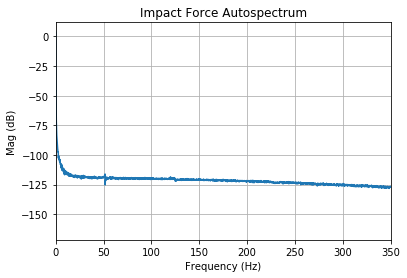

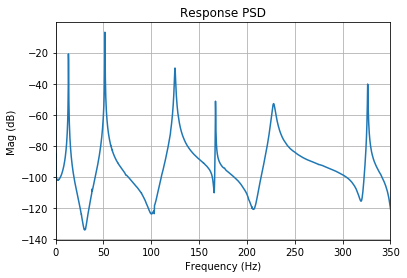

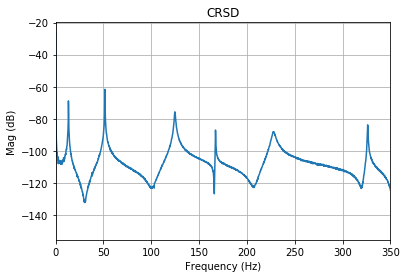

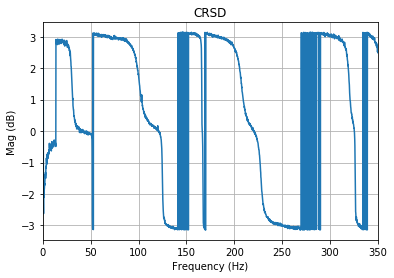

In [10]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/rawdata_1.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
Time_data= np.transpose(Time_data)
rawimpact1 = mat_contents['Time_chan_1']
rawimpact1 = np.array(rawimpact1)
rawresponse1= mat_contents['Time_chan_2']
rawresponse1 = np.array(rawresponse1)
mat_contents=sio.loadmat('modaldata/rawdata_2.mat')
rawimpact2 = mat_contents['Time_chan_1']
rawimpact2 = np.array(rawimpact2)
rawresponse2= mat_contents['Time_chan_2']
rawresponse2 = np.array(rawresponse2)
mat_contents=sio.loadmat('modaldata/rawdata_3.mat')
rawimpact3 = mat_contents['Time_chan_1']
rawimpact3 = np.array(rawimpact3)
rawresponse3= mat_contents['Time_chan_2']
rawresponse3 = np.array(rawresponse3)

x= np.column_stack((rawresponse1,rawresponse2,rawresponse3))
x=np.array([x]).reshape(1,16384,3)

f= np.column_stack((rawimpact1,rawimpact2,rawimpact3))
f=np.array([f]).reshape(1,16384,3)

[freq,Pxx]=vt.asd(x,Time_data,windowname="none")

[freq,Pff]=vt.asd(f,Time_data,windowname="none")

[freq,Pxf]=vt.crsd(f,x,Time_data,windowname="none")

freq=np.array([freq]).reshape(1,8193)


fig=plt.figure()
plt.title('Impact Force Autospectrum')
plt.plot(freq.T, 20*np.log10(abs(Pff)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('Response PSD')
plt.plot(freq.T, 20*np.log10(abs(Pxx)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('CRSD')
plt.plot(freq.T, 20*np.log10(abs(Pxf)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('CRSD')
plt.plot(freq.T, np.angle(Pxf).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)


### FRF Alternative Estimators:  

If the coherence is good we can either go with either H1 or H2, the default FRF is H1. To be more accurate for the systems, below would be the best table to follow:

![alt](img/estimates)


### Demonstration of H1, H2, Coherence

(0, 350)

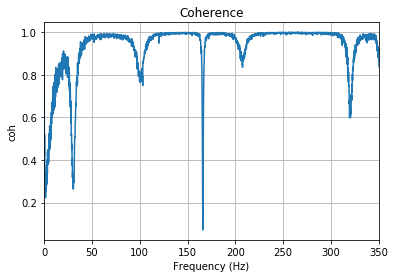

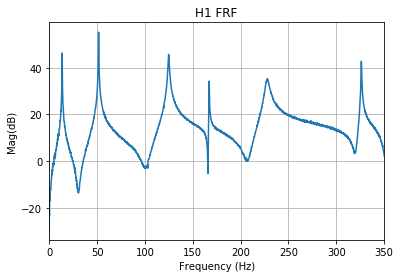

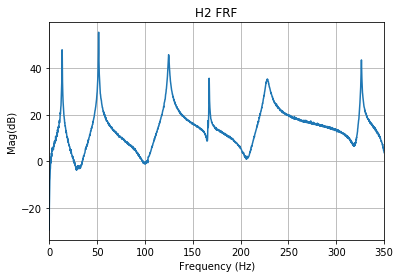

In [36]:
H1=np.conj(Pxf/Pff)
H2=Pxx/Pxf
coh=(Pxf*np.conj(Pxf)).real/Pxx/Pff

fig=plt.figure()
plt.title('Coherence')
plt.plot(freq.T, coh.T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid()
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('H1 FRF')
plt.plot(freq.T, 20*np.log10(abs(H1)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag(dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('H2 FRF')
plt.plot(freq.T, 20*np.log10(abs(H2)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag(dB)')
plt.grid()
plt.xlim(xmax=350, xmin=0)


## In Summary:  

If we observe H1 FRF as well as the coherence obtained which is almost 0.9 but we hit spots where the coherence is low and that would happen at the anti-resonance. Depending on how the modes add or subtract,  then we can have these deep valleys and this deep valley indicates that we have very little vibration, so small that we may be very close to the environmental noise so the coherence drop. However, it's not a bad to have low coherence at anti-resonance. 

#### Typical reasons for Low Coherence: 

*** Difficult measurements:***

- Noise in measured output signal
- Noise in measured input signal
- Other inputs not correlated with measured input signal

*** Bad measurements:***

- Leakage
- Time varying systems
- Non-linearities of system
- DOF-jitter

### 2. Linearity Checks:

A structure FRF is independent of the excitation if it is linear. So the Linearity check is done when exciting the structure at various levels obtaining the same values for the FRF.
![alt](img/Linearity)

**Averaging:** The averaging is also very useful when the excitation that we are using is random, which means that the excitation varies in amplitude randomly, and the response will follow. The input-output relation should be a straight line if we have linear system(double the excitation, double the response). And if we have some random errors going every where then averaging would give the best fit for the relationship.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb3b04cc128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb3b02ad4e0>)

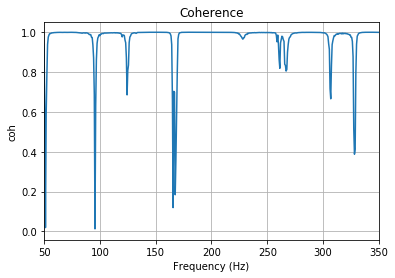

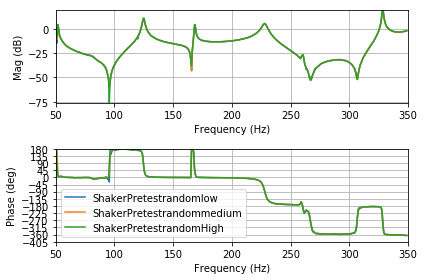

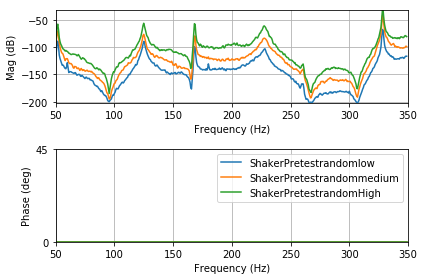

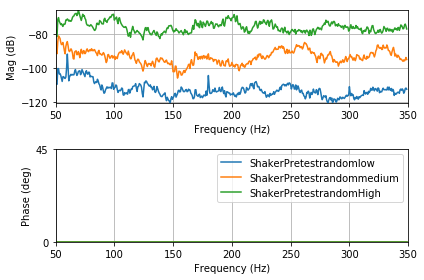

In [37]:
%matplotlib inline
mat_contents=sio.loadmat('linearitycheck/high.mat')
Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
#Frequency= np.transpose(Frequency)
Highresponse = mat_contents['Hf_chan_2']
Highresponse = np.array(Highresponse)
PSDHighresponse = mat_contents['PSD_chan_2']
PSDHighresponse = np.array(PSDHighresponse)
PSDHighLevelRandom = mat_contents['PSD_chan_1']
PSDHighLevelRandom = np.array(PSDHighLevelRandom)
coh = mat_contents['Hf_coh_chan_2']
coh = np.array(coh)

mat_contents=sio.loadmat('linearitycheck/med.mat')

mediumresponse = mat_contents['Hf_chan_2']
mediumresponse = np.array(mediumresponse)
PSDmediumresponse = mat_contents['PSD_chan_2']
PSDmediumresponse = np.array(PSDmediumresponse)
PSDmediumLevelRandom = mat_contents['PSD_chan_1']
PSDmediumLevelRandom = np.array(PSDmediumLevelRandom)
mat_contents=sio.loadmat('linearitycheck/low.mat')

lowresponse = mat_contents['Hf_chan_2']
lowresponse = np.array(lowresponse)
PSDlowresponse = mat_contents['PSD_chan_2']
PSDlowresponse = np.array(PSDlowresponse)
PSDlowLevelRandom = mat_contents['PSD_chan_1']
PSDlowLevelRandom = np.array(PSDlowLevelRandom)

FRFs= np.column_stack((lowresponse,mediumresponse,Highresponse))
VibAutospectrum= np.column_stack((PSDlowresponse,PSDmediumresponse,PSDHighresponse))
ForceAutospectrum= np.column_stack((PSDlowLevelRandom,PSDmediumLevelRandom,PSDHighLevelRandom))
FRFs=np.array(FRFs)
VibAutospectrum=np.array(VibAutospectrum)
ForceAutospectrum=np.array(ForceAutospectrum)
#fig=plt.figure()
#plt.title('Impact PSD')
#plt.plot(Frequency.T, 20*np.log10(abs(Highresponse)).T)
#plt.plot(Frequency.T, 20*np.log10(abs(medresponse)).T)
#plt.plot(Frequency.T, 20*np.log10(abs(lowresponse)).T)
#plt.xlabel('Frequency (Hz)')
#plt.ylabel('psd(dB)')
#plt.grid()
#plt.xlim(xmax=350, xmin=0)
fig=plt.figure()
plt.title('Coherence')
plt.plot(Frequency, coh)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid()
plt.xlim(xmax=350, xmin=50)
#Highresponse.shape

vt.frfplot(Frequency,FRFs,freq_min=50,freq_max=350,type=1,legend=['ShakerPretestrandomlow','ShakerPretestrandommedium','ShakerPretestrandomHigh'])

vt.frfplot(Frequency,VibAutospectrum,freq_min=50,freq_max=350,type=1,legend=['ShakerPretestrandomlow','ShakerPretestrandommedium','ShakerPretestrandomHigh'])

vt.frfplot(Frequency,ForceAutospectrum,freq_min=50,freq_max=350,type=1,legend=['ShakerPretestrandomlow','ShakerPretestrandommedium','ShakerPretestrandomHigh'])

#vt.frfplot(abs(PSDHighLevelRandom),abs(PSDHighresponse),freq_min=0,freq_max=350,type=1,legend=['Linearisation'])

#plt.plot((abs(PSDHighLevelRandom),(abs(PSDHighresponse))


### 3. Reciprocity Checks

"Maxwell's Reciprocity Theorem" simply stated, a measurement with the excitation at point A and response at point B is equal to the measurement with excitation at point B and the response at point A. So, if the structure is linear then the reciprocity with be good.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb3b0052908>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb3b02c19b0>)

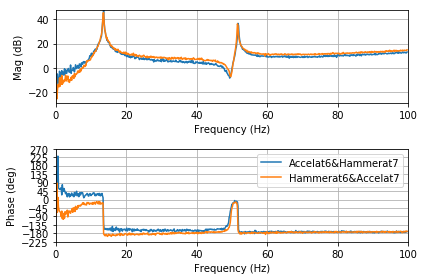

In [38]:
%matplotlib inline
mat_contents=sio.loadmat('reciprocity/accelat6&hammerat7/3.mat')
Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
#Frequency= np.transpose(Frequency)
FRFat6 = mat_contents['Hf_chan_2']
FRFat6 = np.array(FRFat6)

mat_contents=sio.loadmat('reciprocity/hammerat6&accelat7/1-1.mat')
Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
#Frequency= np.transpose(Frequency)
FRFat7 = mat_contents['Hf_chan_2']
FRFat7 = np.array(FRFat7)

FRFs= np.column_stack((FRFat6,FRFat7))
FRFs=np.array(FRFs)

vt.frfplot(Frequency,FRFs,freq_min=0,freq_max=100,type=1,legend=['Accelat6&Hammerat7','Hammerat6&Accelat7'])



### 4. Check of Drive Point Measurement

Drive point: It is the measured response at the excitation point.

Checks:
* An anti-resonance in Mag[Hij] must be found between every pair of resonances.
* Phase fluctuation must be within 180 degrees.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb3b0325ba8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb3b01cae10>)

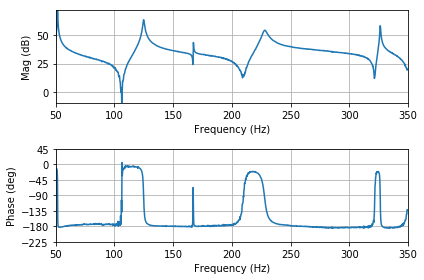

In [39]:
mat_contents=sio.loadmat('modaldata/frf2.mat')
h2 = mat_contents['frf2']
h2 = np.array(h2)
mat_contents=sio.loadmat('modaldata/freqencies.mat')
f = mat_contents['freqencies']
f = np.array(f)
vt.frfplot(f,h2,freq_min=50,freq_max=350)

### Post-Test Analysis 

FRF data was collected at 18 points on the wing using NIMAX and Bobcat DAQs. An open source experimental modal analysis software called "OpenModal" was used only to animate the mode shapes but original characteristics of each mode were extracted by using Multiple degree of freedom curve fitting code in VibrationTesting module. 

#### Measurement of FRF Matrix: SISO (One row)
* One Roving Excitation
* One Fixed Response (reference)

In [40]:
mat_contents=sio.loadmat('modaldata/frf1.mat')
h1 = mat_contents['frf1']
h1 = np.array(h1)
mat_contents=sio.loadmat('modaldata/frf2.mat')
h2 = mat_contents['frf2']
h2 = np.array(h2)
mat_contents=sio.loadmat('modaldata/frf3.mat')
h3 = mat_contents['frf3']
h3 = np.array(h3)
mat_contents=sio.loadmat('modaldata/frf4.mat')
h4 = mat_contents['frf4']
h4 = np.array(h4)
mat_contents=sio.loadmat('modaldata/frf5.mat')
h5 = mat_contents['frf5']
h5 = np.array(h5)
mat_contents=sio.loadmat('modaldata/frf6.mat')
h6 = mat_contents['frf6']
h6 = np.array(h6)
mat_contents=sio.loadmat('modaldata/frf7.mat')
h7 = mat_contents['frf7']
h7 = np.array(h7)
mat_contents=sio.loadmat('modaldata/frf8.mat')
h8 = mat_contents['frf8']
h8 = np.array(h8)
mat_contents=sio.loadmat('modaldata/frf9.mat')
h9 = mat_contents['frf9']
h9 = np.array(h9)
mat_contents=sio.loadmat('modaldata/frf10.mat')
h10 = mat_contents['frf10']
h10 = np.array(h10)
mat_contents=sio.loadmat('modaldata/frf11.mat')
h11 = mat_contents['frf11']
h11 = np.array(h11)
mat_contents=sio.loadmat('modaldata/frf12.mat')
h12 = mat_contents['frf12']
h12 = np.array(h12)
mat_contents=sio.loadmat('modaldata/frf13.mat')
h13 = mat_contents['frf13']
h13 = np.array(h13)
mat_contents=sio.loadmat('modaldata/frf14.mat')
h14 = mat_contents['frf14']
h14 = np.array(h14)
mat_contents=sio.loadmat('modaldata/frf15.mat')
h15 = mat_contents['frf15']
h15 = np.array(h15)
mat_contents=sio.loadmat('modaldata/frf16.mat')
h16 = mat_contents['frf16']
h16 = np.array(h16)
mat_contents=sio.loadmat('modaldata/frf17.mat')
h17 = mat_contents['frf17']
h17 = np.array(h17)
mat_contents=sio.loadmat('modaldata/frf18.mat')
h18 = mat_contents['frf18']
h18 = np.array(h18)
mat_contents=sio.loadmat('modaldata/freqencies.mat')
f = mat_contents['freqencies']
f = np.array(f)
TF= np.column_stack((h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18))
[Damping1,naturalfreq1,modeshape1]=vt.mdof_cf(f,TF,40,70)
[Damping2,naturalfreq2,modeshape2]=vt.mdof_cf(f,TF,165,255)
[Damping3,naturalfreq3,modeshape3]=vt.mdof_cf(f,TF,470,560)
[Damping4,naturalfreq4,modeshape4]=vt.mdof_cf(f,TF,640,730)
[Damping5,naturalfreq5,modeshape5]=vt.mdof_cf(f,TF,890,980)
[Damping6,naturalfreq6,modeshape6]=vt.mdof_cf(f,TF,1290,1390)



![alt](img/modeshape1.png) | ![alt](img/modeshape2.png) | ![alt](img/modeshape3.png) | ![alt](img/modeshape4.png) | ![alt](img/modeshape5.png) | ![alt](img/modeshape6.png)

## MAC:

The Modal Assurance Criterion (MAC) analysis is used to determine the similarity of two mode shapes:

* If the mode shapes are identical (i.e., all points move the same) the MAC will have a value of one or 100%. 
* If the mode shapes are very different, the MAC value will be close to zero.
 
*Note: A MAC analysis is only looking at the mode shape, it does not compare the frequency value.* 
 
### MAC Equation:
 
The MAC value between two modes is essentially the normalized dot product of the complex modal vector at each common nodes (i.e., points), as shown in Equation.  It can also be thought of as the square of correlation between two modal vectors φr and φs. Equation below is the Modal Assurance Criterion equation for comparing two mode shapes:



![alt](img/image.png)


If a linear relationship exists (i.e., the vectors move the same way) between the two complex vectors, the MAC value will be near to one. If they are linearly independent, the MAC value will be small (near zero).
 
A complex vector simply includes both amplitude and phase, whereas a real vector is real part only. In Equation, it is also clear that the MAC is not sensitive to scaling, so if all mode shape components are multiplied with the same factor, the MAC will not be affected.

If an experimental modal analysis had 18 different nodes where measurements were made, the mode shape components at all 18 nodes are taken into account to calculate the MAC value, but more importance will be attributed to the higher amplitude node locations.
             
### Uses:
 
A Modal Assurance Criterion (or MAC) analysis can be used in several different ways:
 
* Test-Test comparison – A MAC analysis can flag potential issues with the modal analysis results. Usually MAC will identify modes and areas that could benefit from acquiring more data points on the structure.
* FEA-FEA comparison – Several assumptions can be made in the creation of a FEA analysis: Young’s Modulus, boundary conditions, and mass density values to name a few. A MAC analysis can determine the degree to which these assumptions affect the resulting mode shapes.
* FEA-Test comparison – A MAC can be used to compare modes from an experimental modal analysis test to a Finite Element Analysis (FEA). It will indicate if the same mode shapes are found in both the test and FEA analysis.

### Resulting Eigen Vectors from Testing:

Here, considered the case of an experimental modal analysis performed on a wing, suspended free on one end and clamped on the other. Frequency Response Function (FRF) data was acquired at 18 locations on the wing. The FRF data was analyzed and a mode set extracted. 

In [41]:
mat_contents=sio.loadmat('Modeshapedata/1stNaturalFreq15.mat')
U1 = mat_contents['U1']
mat_contents=sio.loadmat('Modeshapedata/2ndNaturalFreq15.mat')
U2 = mat_contents['U2']
mat_contents=sio.loadmat('Modeshapedata/3rdNaturalFreq15.mat')
U3 = mat_contents['U3']
mat_contents=sio.loadmat('Modeshapedata/4rthNaturalFreq15.mat')
U4 = mat_contents['U4']
mat_contents=sio.loadmat('Modeshapedata/5thNaturalFreq15.mat')
U5 = mat_contents['U5']
mat_contents=sio.loadmat('Modeshapedata/6thNaturalFreq15.mat')
U6 = mat_contents['U6']
Psi_1 = np.array(U1)
Psi_2 = np.array(U2)
Psi_3 = np.array(U3)
Psi_4 = np.array(U4)
Psi_5 = np.array(U5)
Psi_6 = np.array(U6)
Psi_1=np.column_stack((Psi_1,Psi_2,Psi_3,Psi_4,Psi_5,Psi_6))
Psi_abs = np.abs(Psi_1)*np.real(np.sign(Psi_1))
Psi_1 = Psi_abs

### Test-Test Comparison:

The important thing to remember while we do modal analysis is that, when we have some sort of a structure, then we need to know how many points along the structure to test. For instance, initially, the wing structure was tested taking a guess of number of points as nine to capture all of our mode shapes accurately, however, it was noticed that the modes seen essentially looks like rigid body motion at higher frequencies.

It is quite similar to aliasing, when we think about reading in frequencies where we did not sample high enough, but here its about not considering enough points on the structure. So, one way to check that enough points were used to accurately capture all versus different mode shapes by using something called the MAC matrix.

In [42]:
vt.mac(Psi_1,Psi_1)

array([[ 1.         ,  0.012878134,  0.024564134,  0.021402321,  0.04530025 ,  0.00297411 ],
       [ 0.012878134,  1.         ,  0.05357427 ,  0.003010583,  0.008900821,  0.01555768 ],
       [ 0.024564134,  0.05357427 ,  1.         ,  0.002131827,  0.162034548,  0.00183518 ],
       [ 0.021402321,  0.003010583,  0.002131827,  1.         ,  0.000965057,  0.020653144],
       [ 0.04530025 ,  0.008900821,  0.162034548,  0.000965057,  1.         ,  0.000017919],
       [ 0.00297411 ,  0.01555768 ,  0.00183518 ,  0.020653144,  0.000017919,  1.         ]])

Acquiring an additional 9 points leads to better results.  With 18 total points, the mode shapes look completely different. So, with less response points, the spatial aliasing error was created.

*Note: The term used of "not enough response points" is called "Spacial Aliasing".*

In the above case, this is a mode set compared to itself.  The mode set contains six different individual modes, so 36 different MAC values are being calculated. About half the values are redundant –e.g., the MAC value between mode 1 and 3 is the same as between mode 3 and 1.

The first mode shape at 13 Hz is identical to itself, hence a value of 1. Along the diagonal, every mode is identical to itself, 1 to 1 (13 Hz), 2 to 2 (51 Hz), 3 to 3 (121 Hz), etc.

Off of the diagonal, the MAC values are very low.  Ideally, each mode should be uniquely observed and have a different shape than the other modes.  This is the case for this mode set.  The highest off diagonal mode pair is mode 5 compared to mode 3 (and vice versa 3 to 5) with a MAC value of 16%. All the other off-diagonal mode pairs are below 16%. 

In experimental modal analysis, the data measured in the 9 point modal analysis is not "wrong". The FRF measurements at these nodes were no different in the 9 point modal versus the 18 point, since the physical structure being tested did not change.  There was simply not enough measurement points to determine the complete mode shape.  This is different than a Finite Element modal analysis were the number of nodes does determine the dynamic behavior.

### Extension of modes from Modal Analysis to All DOF of a Finite Element Model after applying Guyan reduction:

Only guyan reduction was applied on the full M and K from the created model using WFEM module(Matlab) to reduce the M and K matrix. SEREP could be applied to reduce the M and K matrices further, however, in this case it would not give accurate results as only 6 mode shapes are retained which would result in a very small 6x6 sized M and K matrices.

In [43]:
mat_contents=sio.loadmat('FEmodaldata/WingBeamforMAC.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbm = K.todense()
Mbm = M.todense()
omega, zeta, PsiBM = vt.sos_modal(Mbm, Kbm)
measured = np.array([[1,6,11,16,21,26,31,36,41,46,51,56,61,66,71]])
omega=np.array([omega[0], omega[1], omega[3], omega[4], omega[5], omega[6]])
Psi_fullBM=vt.mode_expansion_from_model(Psi_1, omega, Mbm, Kbm, measured)

In [44]:
mat_contents=sio.loadmat('FEmodaldata/WingBrickmuchMorMeshedforMAC1.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbr = K.todense()
Mbr = M.todense()
omega, zeta, PsiBR = vt.sos_modal(Mbr, Kbr)
measured = np.array([[350, 347, 344, 278, 275, 272, 206, 203, 200, 134, 131, 128, 62, 59, 56]])
omega=np.array([omega[0], omega[1], omega[3], omega[4], omega[5], omega[6]])
Psi_fullBR=vt.mode_expansion_from_model(Psi_1, omega, Mbr, Kbr, measured)

So, the alternative to reducing the matrices from the finite element model is to expand the measured mode shape vectors to estimate the data at unmeasured locations. Expanding the measured data invariably involves using the finite element model to fill in the missing data. The vibration testing module in python has the function mode_expansion_from_model which does the expansion process for us.

### Resulting eigen vectors from FE model:

In [45]:
Psi_1 = PsiBM
mode1=Psi_1[:,0]
mode2=Psi_1[:,1]
mode3=Psi_1[:,3]
mode4=Psi_1[:,4]
mode5=Psi_1[:,5]
mode6=Psi_1[:,6]
Psi_2BM= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))

In [46]:
Psi_1 = PsiBR
mode1=Psi_1[:,0]
mode2=Psi_1[:,1]
mode3=Psi_1[:,3]
mode4=Psi_1[:,4]
mode5=Psi_1[:,5]
mode6=Psi_1[:,6]
Psi_2BR= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))

### FE-FE comparison: 

The below off-diagonal MAC values tell how bad the assumptions made were. We can observe that off-diagonal terms for the Brick model look better because of more mesh. 

In [47]:
vt.mac(Psi_2BM,Psi_2BM)

array([[ 1.         ,  0.28416901 ,  0.172196744,  0.         ,  0.132407293,  0.         ],
       [ 0.28416901 ,  1.         ,  0.371274112,  0.         ,  0.235979076,  0.         ],
       [ 0.172196744,  0.371274112,  1.         ,  0.         ,  0.379744752,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  1.         ,  0.         ,  0.240949039],
       [ 0.132407293,  0.235979076,  0.379744752,  0.         ,  1.         ,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  0.240949039,  0.         ,  1.         ]])

In [48]:
vt.mac(Psi_2BR,Psi_2BR)

array([[ 1.         ,  0.122984639,  0.041348987,  0.         ,  0.026004283,  0.         ],
       [ 0.122984639,  1.         ,  0.157153609,  0.         ,  0.060581719,  0.         ],
       [ 0.041348987,  0.157153609,  1.         ,  0.         ,  0.168759104,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  1.         ,  0.         ,  0.10115887 ],
       [ 0.026004283,  0.060581719,  0.168759104,  0.         ,  1.         ,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  0.10115887 ,  0.         ,  1.         ]])

###  FE-Test Comparison:

After collecting Frequency Response Functions (FRFs) on the wing, a MAC analysis was done between the first six experimental test modes and the first six finite element analysis modes.  The results are shown below.

In [49]:
vt.mac(Psi_fullBM,Psi_2BM)

array([[ 0.902776121,  0.08397938 ,  0.133234332,  0.000280447,  0.069636931,  0.000567165],
       [ 0.157055975,  0.892874372,  0.1246398  ,  0.000251338,  0.095492976,  0.000255381],
       [ 0.029469884,  0.217923327,  0.896786436,  0.000113918,  0.154537904,  0.000015324],
       [ 0.009130519,  0.00258551 ,  0.001044216,  0.10351289 ,  0.00068626 ,  0.087508   ],
       [ 0.071166016,  0.067331544,  0.34484064 ,  0.000039387,  0.854315037,  0.000332692],
       [ 0.007015925,  0.009076935,  0.000333458,  0.899795777,  0.001109486,  0.124936721]])

In [50]:
vt.mac(Psi_fullBR,Psi_2BR)

array([[ 0.419687707,  0.000826393,  0.002039278,  0.000059746,  0.004514538,  0.000070361],
       [ 0.010436219,  0.383714861,  0.000050142,  0.000000193,  0.001243138,  0.000022064],
       [ 0.038379026,  0.000165336,  0.299634258,  0.000027009,  0.000093382,  0.000075664],
       [ 0.017322709,  0.001122434,  0.000278439,  0.492081088,  0.000266308,  0.014127599],
       [ 0.013926318,  0.069706433,  0.002956606,  0.000573113,  0.236123559,  0.000164655],
       [ 0.004917083,  0.007407191,  0.003720332,  0.005166634,  0.000011543,  0.428847769]])

Looking at the diagonal and off-diagonal of the MAC matrix:

Beam model observations: 

* Diagonal MAC values are not 100%, because the two sets of modes are not identical.
* Modes 4 and 6 are less than 25%, the reason being torsional modes.
* The highest off diagonal mode pair is mode 5 compared to mode 3 (and vice versa 3 to 5) with a MAC value of 34%. All the other off-diagonal mode pairs are below 16%.

Brick model:

* Diagonal MAC values are not even 50%, may be because the mode shape locations did not match well.
* Similar to the Beam model, torsional modes have very less diagonal MAC values. 
* The highest off diagonal mode pair is mode 1 compared to mode 3 (and vice versa 3 to 1) with a MAC value of 3%. All the other off-diagonal mode pairs are below 3%.

In this case, the MAC analysis indicates that there is room for improvement in the correlation of the test and FEA. This 
can be done by correcting the M and K from FE model using 'Baruch' method

### FE Beam model Correction:

Baruch method of model correction is a Direct model updating Technique using modal data. This can be simply be performed using the model_correction_direct function in the vibration testing module in Python.


In [51]:
omega=np.array([13.54, 51.81, 125.19, 167.76, 228.05, 328.41])
Mc, Kc = vt.model_correction_direct(Psi_fullBM, omega, Mbm, Kbm, method='Baruch')
omega, zeta, PsiBM = vt.sos_modal(Mc, Kc)
Psi_2 = PsiBM
mode1=Psi_2[:,0]
mode2=Psi_2[:,1]
mode3=Psi_2[:,2]
mode4=Psi_2[:,3]
mode5=Psi_2[:,4]
mode6=Psi_2[:,5]
Psi_2BM= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))

In [52]:
omega=np.array([13.54, 51.81, 125.19, 167.76, 228.05, 328.41])
Mc, Kc = vt.model_correction_direct(Psi_fullBR, omega, Mbr, Kbr, method='Baruch')
omega, zeta, PsiBR = vt.sos_modal(Mc, Kc)
Psi_2 = PsiBR
mode1=Psi_2[:,0]
mode2=Psi_2[:,1]
mode3=Psi_2[:,2]
mode4=Psi_2[:,3]
mode5=Psi_2[:,4]
mode6=Psi_2[:,5]
Psi_2BR= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))

In [53]:
vt.mac(Psi_fullBM,Psi_2BM)

array([[ 0.881321121,  0.038974652,  0.026369503,  0.022319756,  0.043063273,  0.004626752],
       [ 0.151688823,  0.966339971,  0.083540347,  0.000101145,  0.00984486 ,  0.012454445],
       [ 0.026114408,  0.130064798,  0.985585275,  0.000779997,  0.146162695,  0.000792393],
       [ 0.000705308,  0.000182381,  0.000003272,  0.958222761,  0.000485955,  0.055843798],
       [ 0.016009234,  0.033694923,  0.135101087,  0.00022769 ,  0.999311401,  0.000000001],
       [ 0.000009955,  0.001125275,  0.002966466,  0.116284286,  0.000000452,  0.990680361]])

In [54]:
vt.mac(Psi_fullBR,Psi_2BR)

array([[ 0.698262238,  0.000359566,  0.001196876,  0.033783873,  0.000001657,  0.002985744],
       [ 0.08548994 ,  0.798983181,  0.011013081,  0.000197895,  0.016457018,  0.014427994],
       [ 0.01609378 ,  0.065317434,  0.895059712,  0.001135323,  0.055996187,  0.003718399],
       [ 0.025364975,  0.003495387,  0.004594898,  0.96107467 ,  0.000053346,  0.018941836],
       [ 0.013595906,  0.008849519,  0.049541316,  0.000901858,  0.978078484,  0.001089207],
       [ 0.004008585,  0.002180803,  0.030543414,  0.052915722,  0.000170555,  0.987921688]])

So, after updating the model the MAC matrix results improved drastically. When comparing the three observations made before correcting the model to after correcting:

* MAC values are still not 100%, but very close enough .
* MAC values of the torsional modes were improved to great extent.
* The highest off diagonal mode pair is mode 5 compared to mode 3 (and vice versa 3 to 5) with a MAC value of 34% before is now 13.5%. All the other off-diagonal mode pairs are below 16%. Thats for the Beam model. However, for the Brick off-diagonal terms increased.


### Conclusion:

A Modal Assurance Criterion (or MAC) analysis can be used for FEA-Test, FEA-FEA and Test-Test comparisons of modes. By analyzing a MAC matrix, an engineer can improve the quality of an experimental modal test, verify finite element models, and update FEA models with test data.